In [7]:
import numpy as np
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from scipy import signal
from scipy.integrate import quad

import scipy
import scipy.io as sio
import scipy.fftpack

# функцции

In [8]:
def cos_signal_func(freq):
    w = 2 * np.pi * freq
    def cos_func(t): return np.cos(t * w)
    return cos_func

def mean(signal, k):
    averaged_signal = []
    for i in range(k, len(signal)-k):
        s = np.sum(signal[i-k:i+k])
        averaged_signal.append(s * (2*k+1)**-1)
    return np.pad(averaged_signal, (k, k))

def mean_gauss(signal, k, w):
    smoothed_signal = np.zeros(len(signal))
    t_values = np.arange(k, len(signal) - k)

    for t in t_values:
        i_values = np.arange(t - k, t + k) 
        weights = np.exp(-4 * np.log(2) * (i_values - t)**2 / w**2)
        total_weight = np.sum(weights)
        weighted_sum = np.sum(signal[i_values] * weights)
        smoothed_signal[t] = weighted_sum / total_weight

    return smoothed_signal

def calc_signal(s_func, *args, t_start=0, t_end=1, sample=16384 * 4):
    time_series = np.linspace(t_start, t_end, sample, endpoint=False)
    signal_vals = np.array([s_func(*args, t) for t in time_series])
    return signal_vals, time_series

def get_positive_spectrum(signal, normalize=True, samplerate=16384 * 4):
    spectrum = np.fft.fft(signal)
    positive_spectrum = np.abs(spectrum[:len(spectrum) // 2])
    freq_resolution = samplerate / len(spectrum)
    positive_frequencies = np.arange(len(positive_spectrum)) * freq_resolution
    
    if normalize:
        positive_spectrum /= np.max(positive_spectrum)
    
    return positive_frequencies, positive_spectrum

def interpol(signal, samplerate, gapped_indices_, window_size_=128, overlap=64):
    gapped_indices = gapped_indices_[0]
    gapped_size = len(gapped_indices)
    window_size = gapped_size
    left_gapp_id = gapped_indices[0]
    right_gapp_id = gapped_indices[-1] + 1
    left_part = signal[left_gapp_id-window_size:left_gapp_id]
    right_part = signal[right_gapp_id:right_gapp_id+window_size]
    f1, t1, Zxx1 = stft(left_part, fs=samplerate, nperseg=window_size_, noverlap=overlap)
    f2, t2, Zxx2 = stft(right_part, fs=samplerate, nperseg=window_size_, noverlap=overlap)
    averaged_spectrum = (Zxx1 + Zxx2) / 2
    _, restored_part = istft(averaged_spectrum, fs=samplerate, nperseg=window_size_, noverlap=overlap)
    restored_signal = signal.copy().astype(np.complex128)
    restored_signal[gapped_indices] = restored_part[:len(gapped_indices)]
    return restored_signal 

# решения

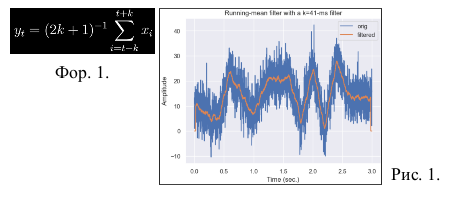

1. Реализовать усреднение зашумленного сигнала по формуле 1. Результат усреднения представлен
на рис.1. Вывести спектр усредненного и зашумленного сигнала. Объяснить результат.

In [9]:
signal_func = lambda x: cos_signal_func(freq=15)(x) + cos_signal_func(freq=20)(x)
task1_sig, cos_time_1 = calc_signal(signal_func)

task1_sig_noised, cos_time_series = calc_signal(signal_func)
task1_sig_noised += np.random.normal(0, 1, task1_sig_noised.shape)
task1_sig_mean = mean(task1_sig_noised, 100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


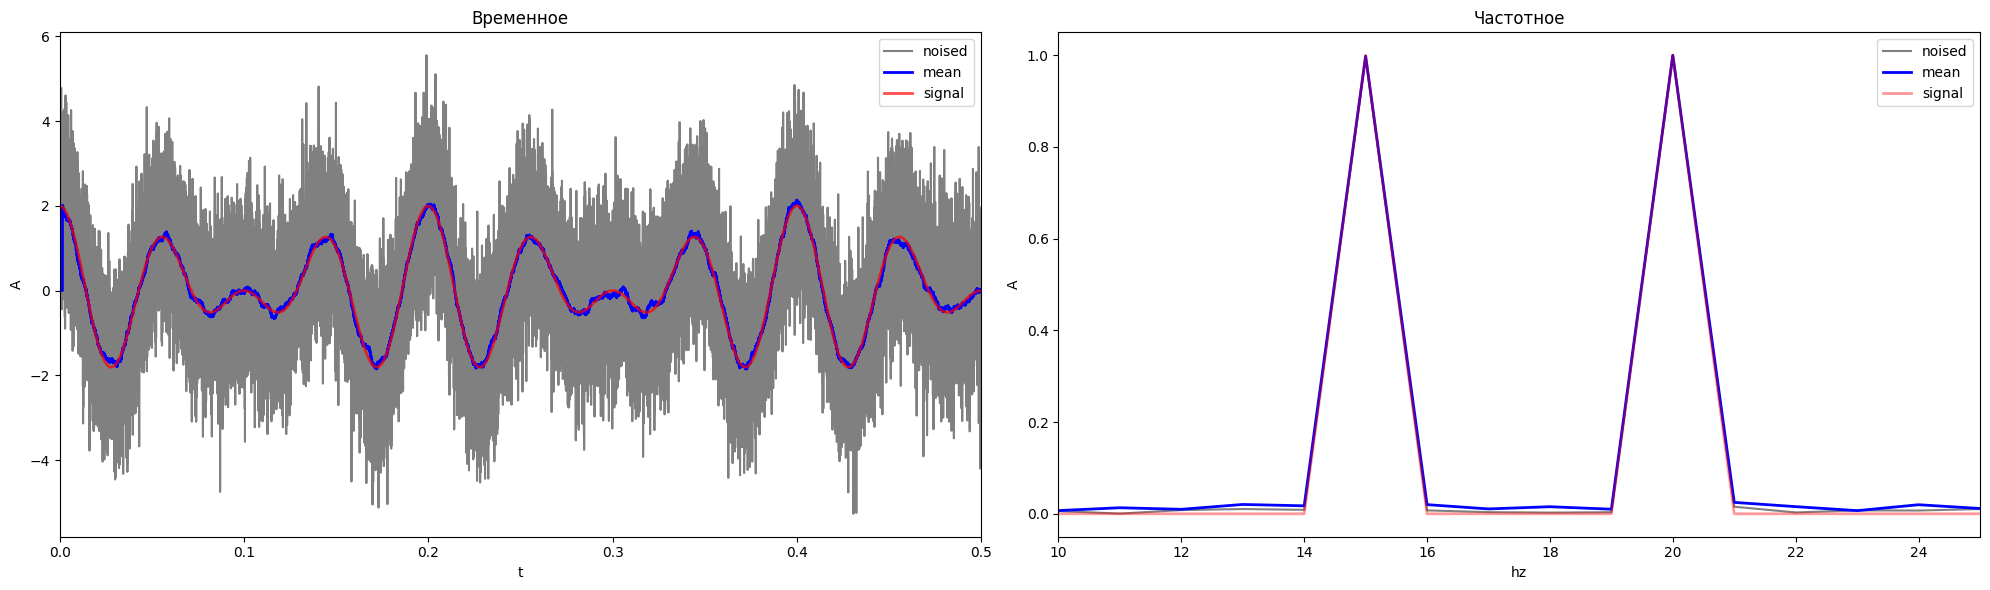

In [10]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.xlabel("t")
plt.ylabel("A")
plt.legend()
plt.title("Временное")
plt.plot(cos_time_series, task1_sig_noised, color='grey', label='noised')
plt.plot(cos_time_series, task1_sig_mean, color='blue', label='mean', linewidth=2)
plt.plot(cos_time_series, task1_sig, color='red', alpha=0.7, label='signal', linewidth=2)
plt.xlim([0, 0.5])
plt.legend()

plt.subplot(122)
plt.title("Частотное")
plt.xlabel("hz")
plt.ylabel("A")

plt.plot(*get_positive_spectrum(task1_sig_noised), color='grey', label='noised')
plt.plot(*get_positive_spectrum(task1_sig_mean), color='blue', label='mean', linewidth=2)
plt.plot(*get_positive_spectrum(task1_sig), color='red', label='signal', alpha=0.4, linewidth=2)
plt.xlim([10, 25])

plt.legend()
plt.tight_layout()
plt.show()

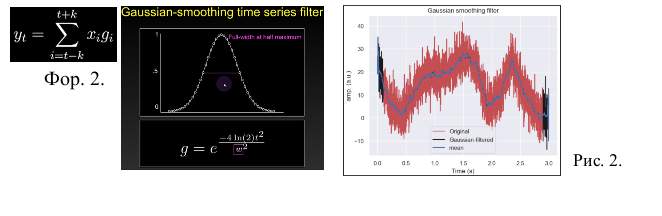

2. Реализовать усреднение зашумленного сигнала по формуле 2. Результат усреднения представлен
на рис.2. Вывести спектр усредненного и зашумленного сигнала. Сопоставить усреднение по
Гауссу и среднему значению, как это сделано на рис.2. Объяснить результат.

In [11]:
signal_func = lambda x: cos_signal_func(freq=15)(x) + cos_signal_func(freq=20)(x)
task2_sig, cos_time_2 = calc_signal(signal_func)

task2_sig_noised, cos_time_series = calc_signal(signal_func)
task2_sig_noised += np.random.normal(0, 1, task2_sig_noised.shape)
task2_sig_mean = mean_gauss(task2_sig_noised, 100, 20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


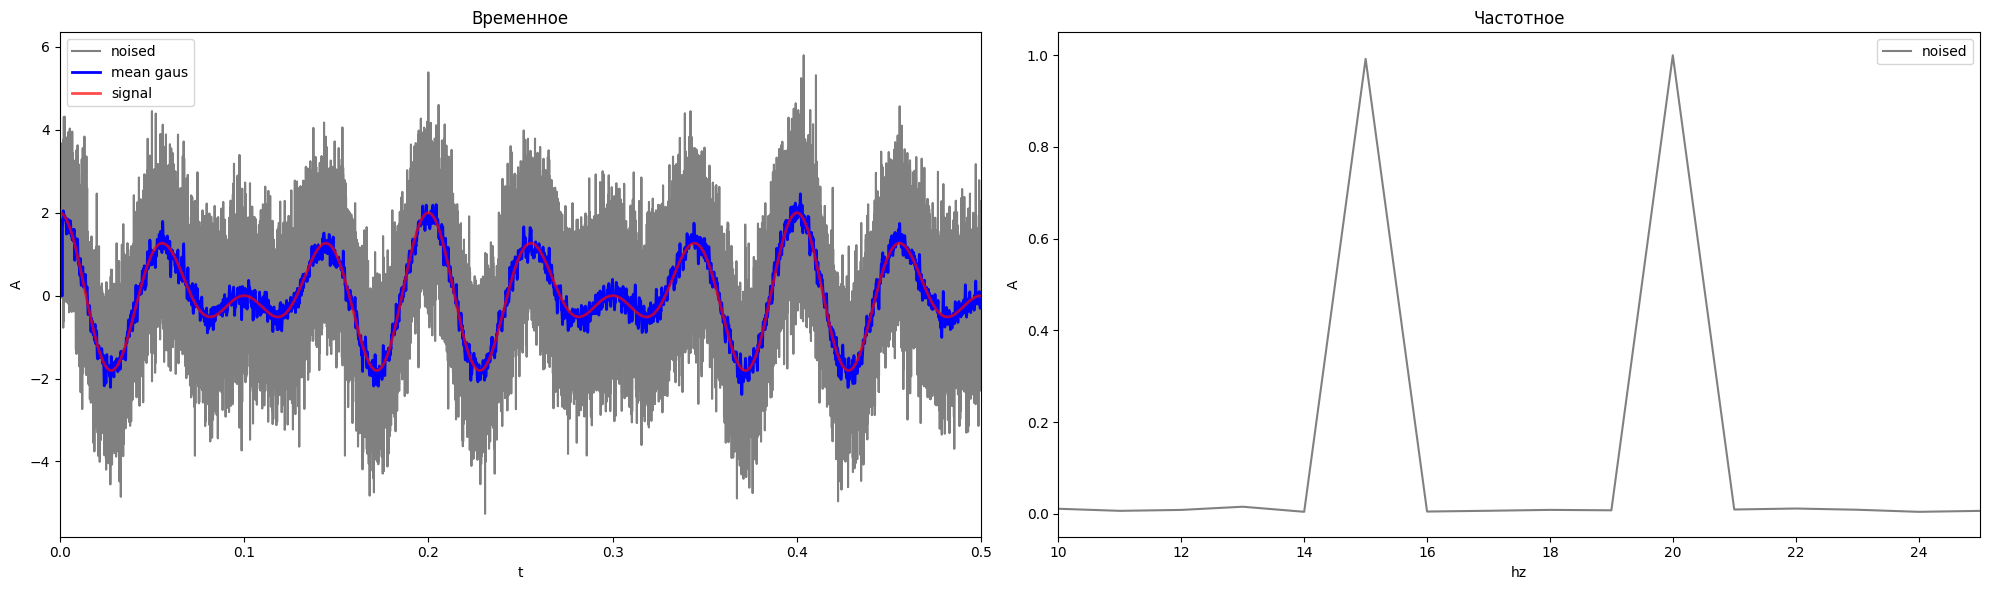

In [27]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.xlabel("t")
plt.ylabel("A")
plt.legend()
plt.title("Временное")
plt.plot(cos_time_series, task2_sig_noised, color='grey', label='noised')
plt.plot(cos_time_series, task2_sig_mean, color='blue', label='mean gaus', linewidth=2)
plt.plot(cos_time_series, task2_sig, color='red', alpha=0.7, label='signal', linewidth=2)
plt.xlim([0, 0.5])
plt.legend()

plt.subplot(122)
plt.title("Частотное")
plt.xlabel("hz")
plt.ylabel("A")

plt.plot(*get_positive_spectrum(task2_sig_noised), color='grey', label='noised')
# plt.plot(*get_positive_spectrum(task2_sig_mean), color='blue', label='mean gaus', linewidth=2)
# plt.plot(*get_positive_spectrum(task2_sig), color='red', label='signal', alpha=0.4, linewidth=2)
plt.xlim([10, 25])

plt.legend()
plt.tight_layout()
plt.show()

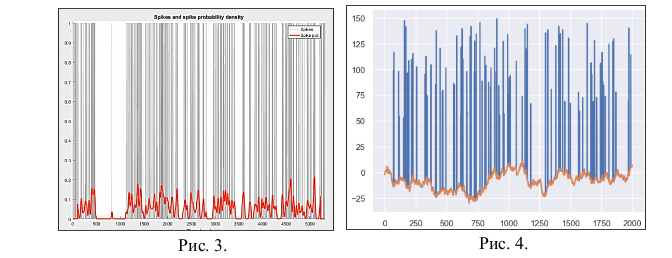

3. Воспользоваться усреднением по Гауссу для обработки сигнала, состоящего из всплесков пиков.
Всплеск каждого пика является случайно величиной. Амплитуда каждого пика A=1 V, рис.3.

In [13]:
# добавление случайных пиков к сигналу
def add_peaks(signal, p=0.2):
    peaks = np.zeros_like(signal)
    peaks[:int(len(signal)*p)-1] = 1
    np.random.shuffle(peaks)
    return signal + peaks

# for random_id in signal:
# signal[random_id] += random(low=0, max=10)
task3_sig = scipy.signal.detrend(np.cumsum(np.random.randn(16384 * 4)))/100
task3_sig /= np.max(task3_sig)

task3_peaked = add_peaks(task3_sig, p=0.009)
task3_peaked_average = mean_gauss(task3_peaked, 100, 20)

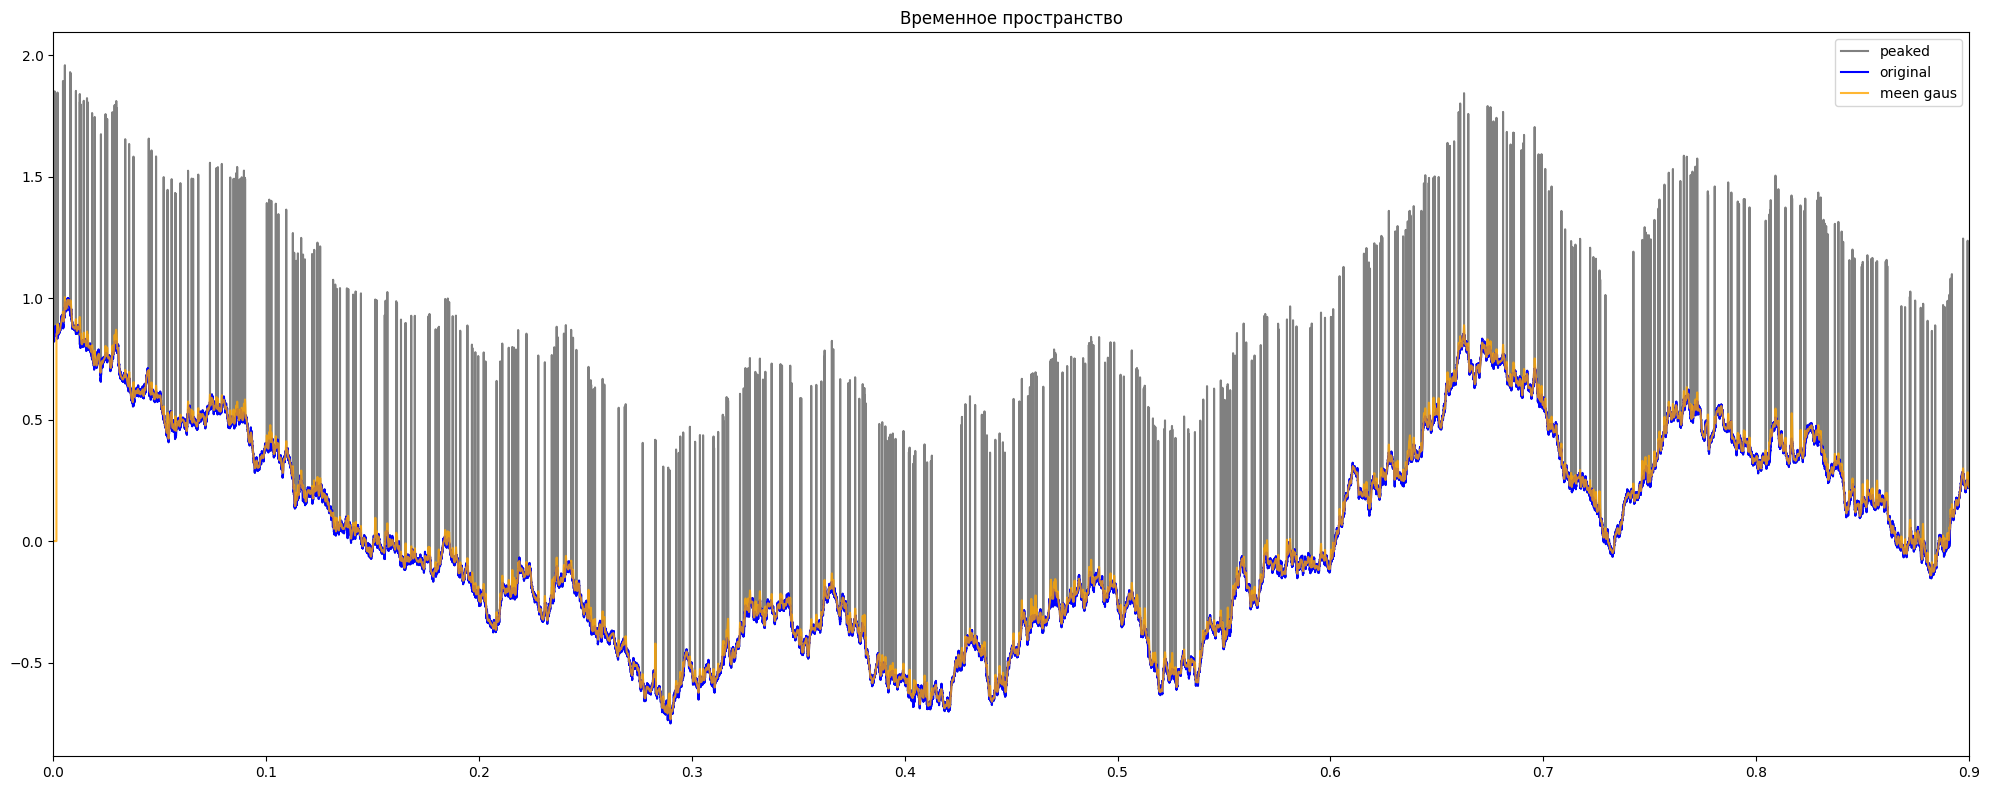

In [14]:
plt.figure(figsize=(20, 8))

plt.title("Временное пространство")
plt.plot(cos_time_series, task3_peaked, color='gray', label='peaked')
plt.plot(cos_time_series, task3_sig, color='blue', label='original')
plt.plot(cos_time_series, task3_peaked_average, color='orange', alpha=0.8, label='meen gaus')
plt.xlim([0, 0.9])

plt.legend()
plt.tight_layout()
plt.show()

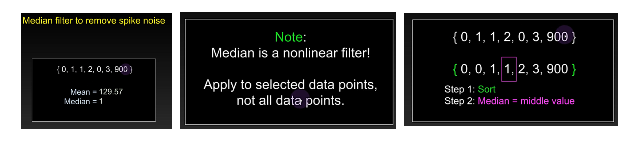

4. Реализовать медианный фильтр для очистки сигнала от случайных всплесков в сигнала. В этом
случае амплитуда всплеска сигнала уже не является постоянной и является случайной величиной.
Результат обработки представлен оранжевой линий на рис. 4.

Замечание: Реализовать фильтрацию лучше в два этапа. Вначале ввести порог, выше которого пик будет
удаляться, затем применить медианный фильтр.

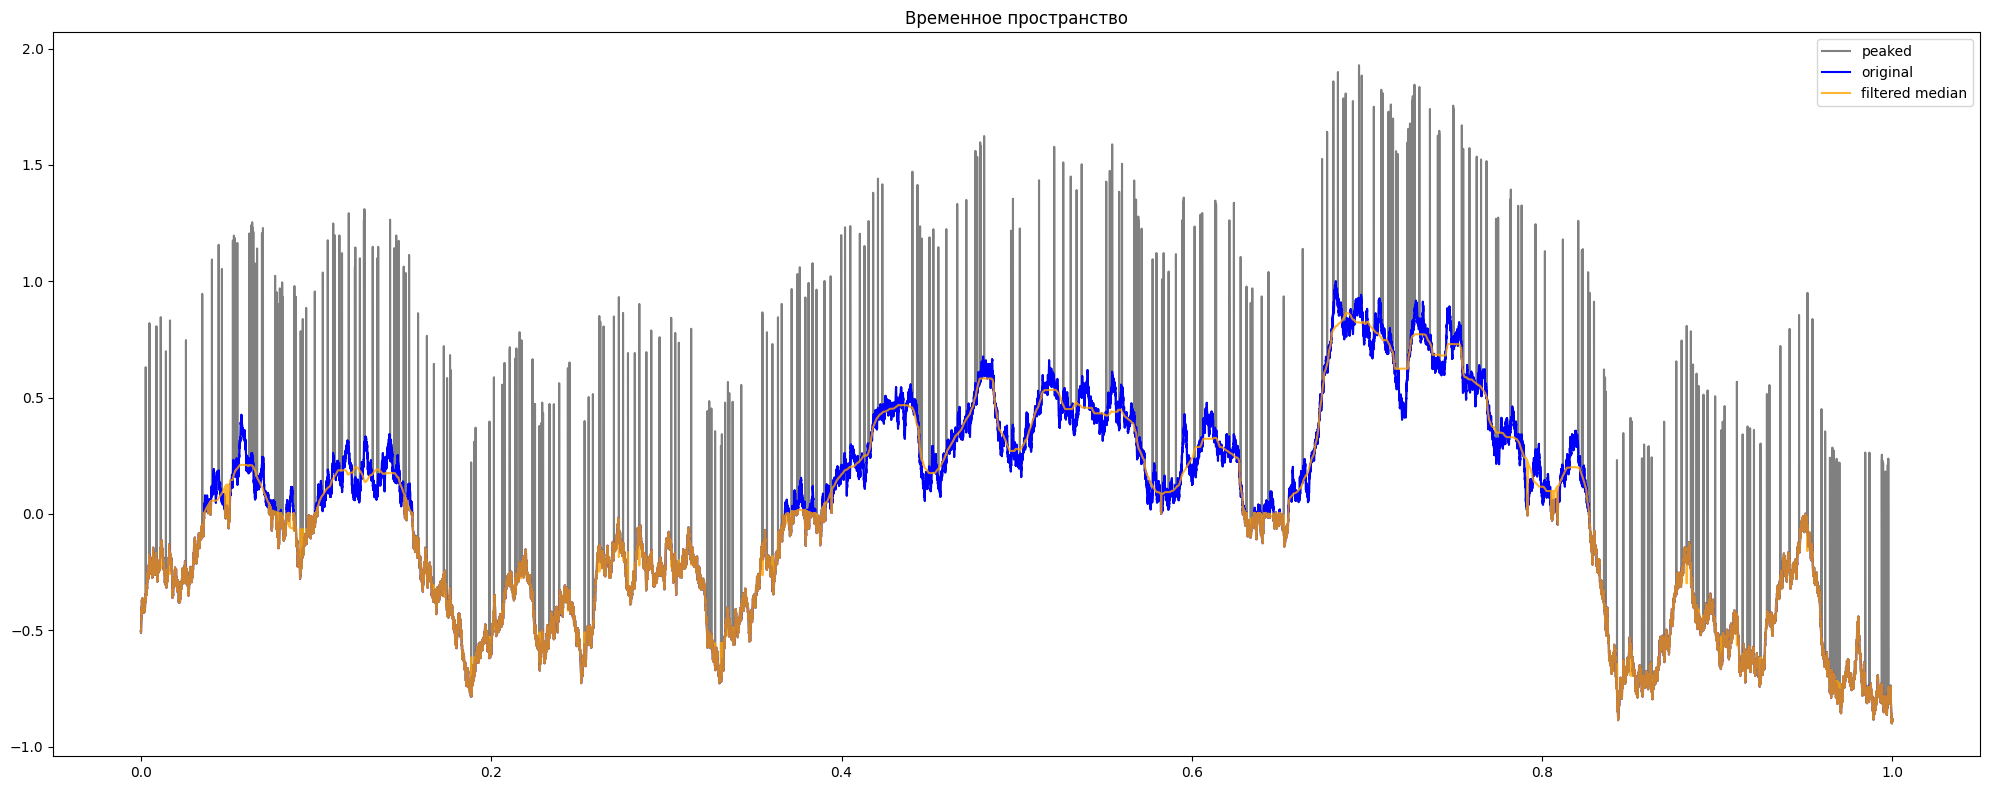

In [25]:
# медианный фильтр только к тем точкам, значение сигнала выше среднего значения.
def median_filter_custom(signal, k):
    signal_with_filter = signal.copy()
    signal_mean = np.mean(signal)
    #  медианный фильтр только к тем точкам, где значение сигнала выше среднего значения.
    mean_up_ids = np.where(signal>signal_mean)
    for ind in mean_up_ids[0]:
        # Вычисляем медиану в окне [ind-k, ind+k] и присваиваем ее отфильтрованному сигналу
        signal_with_filter[ind] = np.median(signal[ind-k:ind+k])
    return signal_with_filter

task4_sig = scipy.signal.detrend(np.cumsum(np.random.randn(16384 * 4)))/100
task4_sig /= np.max(task4_sig)

task4_peaked = add_peaks(task4_sig, p=0.005)
task4_peaked_average = median_filter_custom(task4_peaked, 500)

plt.figure(figsize=(20, 8))

plt.title("Временное пространство")
plt.plot(cos_time_series, task4_peaked, color='grey', label='peaked')
plt.plot(cos_time_series, task4_sig, color='blue', label='original')
plt.plot(cos_time_series, task4_peaked_average, color='orange', alpha=0.8, label='filtered median')

plt.legend()
plt.tight_layout()
plt.show()

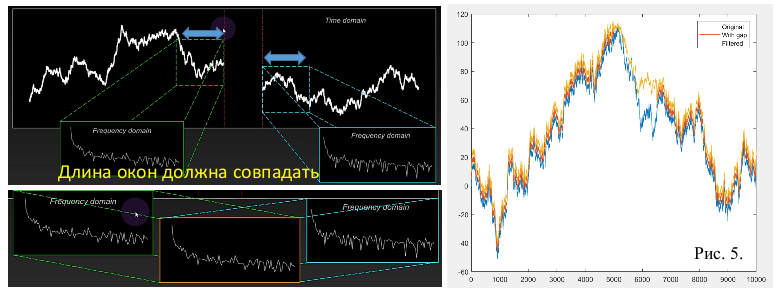

5. Метод спектральной интерполяции сигналов.

Данный метод позволяет восстановить часть сигнала, которая была потеряна или удалена.
Алгоритм реализации метода:

- определить сигнал в заданном временном промежутке, например от 0 до 10 сек.

- удалить из сигнала данные в диапазоне от 5 до 7 секунд.

задать размер окна по временной области для которых будет определяться спектр. Размер окон
для правой и левой части должны совпадать.

определить спектр сигнала до разрыва и после разрыва.

осуществить усреднение спектров сигналов в правой и левой области.

с помощью обратного преобразования Фурье восстановить утерянную часть сигнала.

сшить границы с помощью линейной интерполяции.

Результат работы алгоритма представлен на Рис.5

In [16]:
import numpy as np
from scipy.signal import istft, stft
import matplotlib.pyplot as plt

def spectral_interpolation(signal, gapped_indices_):
    gapped_size = len(gapped_indices_[0]) # размера пропуска
    # определение крайних левого и правого индексов пропуска
    left_id = gapped_indices_[0][0]
    right_id = gapped_indices_[0][-1] + 1
    # извлечение левой и правой частей сигнала вокруг пропуска
    left_part = signal[left_id-gapped_size:left_id]
    right_part = signal[right_id:right_id+gapped_size]
    # вычисление преобразования Фурье (спектра) для левой и правой частей
    left_part_spectrum = np.fft.fft(left_part)
    right_part_spectrum = np.fft.fft(right_part)
    # усредненили
    restored_part_spectrum = (left_part_spectrum + right_part_spectrum)/2
    # получения восстановленной части сигнала
    restored_part = np.fft.ifft(restored_part_spectrum)
    restored_signal = signal.copy().astype(np.complex128)
    # востановили
    restored_signal[gapped_indices_[0]] = restored_part
    return restored_signal

In [17]:
left_delete_sig = 0.5
right_delete_sig = 0.7

task5_timeseries = cos_time_series.copy()

task5_sig = scipy.signal.detrend(np.cumsum(np.random.randn(16384 * 4)))
task5_sig /= np.max(task5_sig)

task5_sig_gapped = task5_sig.copy()
task5_timeseries_gapped = task5_timeseries.copy()

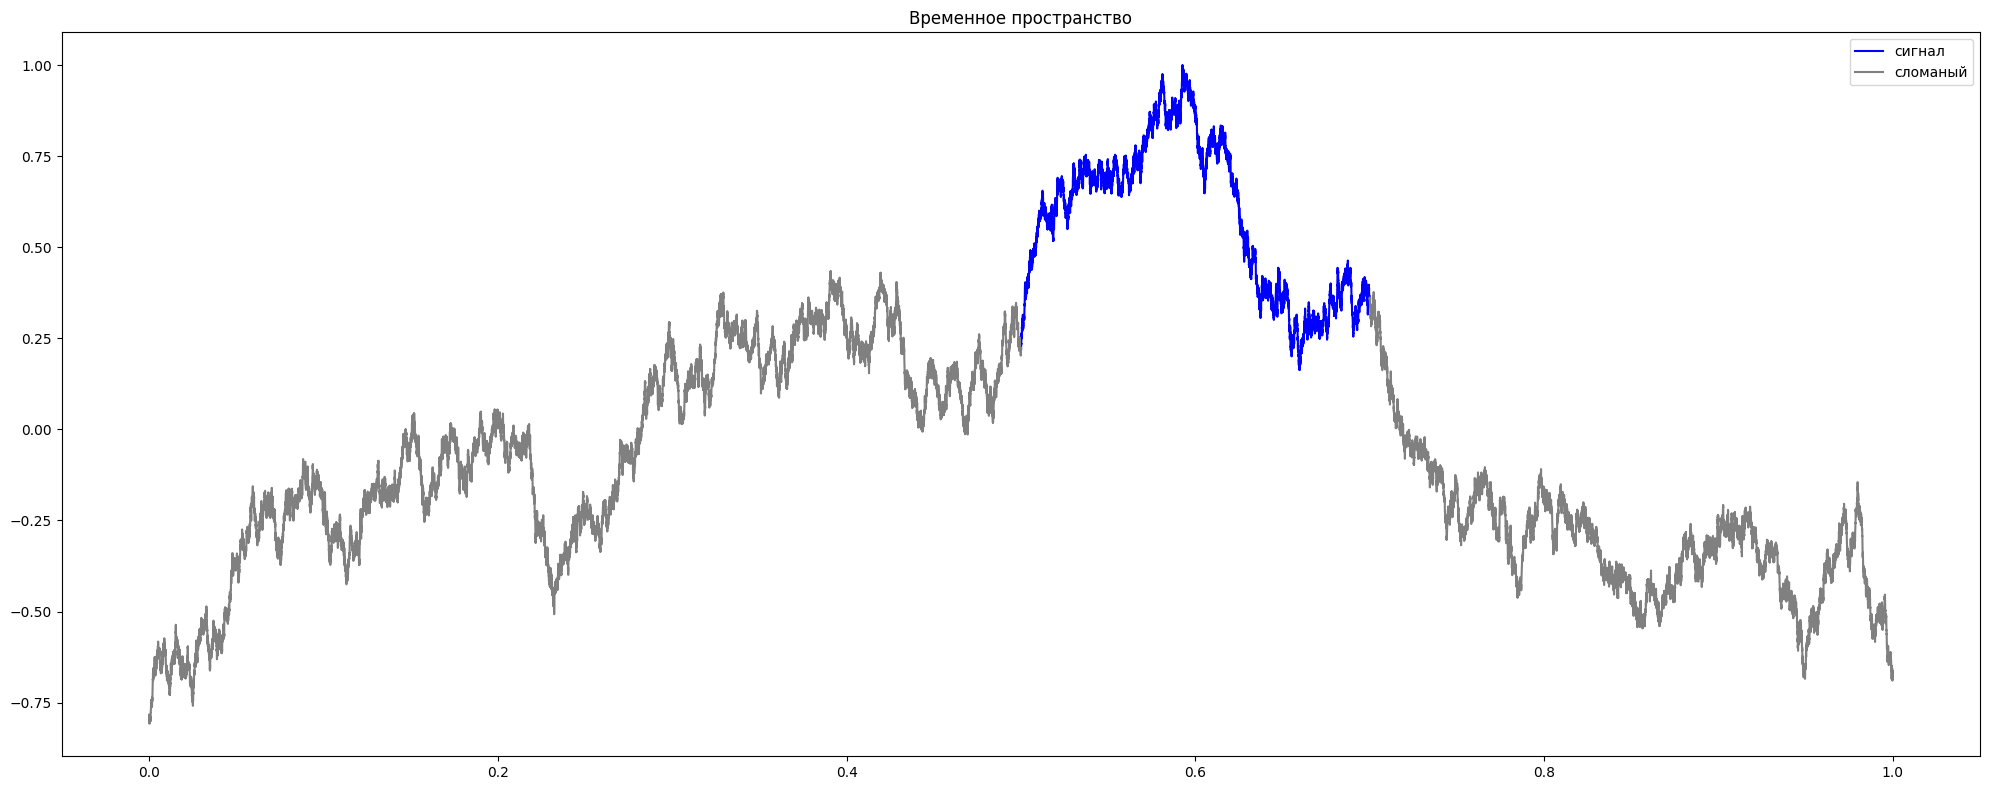

In [18]:
task5_timeseries_gapped[(task5_timeseries>left_delete_sig) & (task5_timeseries < right_delete_sig)] = np.NaN
task5_sig_gapped[(task5_timeseries>left_delete_sig) & (task5_timeseries <right_delete_sig)] = np.NaN

restored_signal = spectral_interpolation(task5_sig_gapped, np.where((task5_timeseries>left_delete_sig) & (task5_timeseries < right_delete_sig)))

# spect_interpol = interpol(task5_sig_gapped, 16384 * 4, np.where((task5_timeseries>left_delete_sig) & (task5_timeseries < right_delete_sig)))

plt.figure(figsize=(20, 8))

plt.title("Временное пространство")
plt.plot(task5_timeseries[(task5_timeseries>left_delete_sig) & (task5_timeseries <right_delete_sig)], task5_sig[(task5_timeseries>left_delete_sig) & (task5_timeseries < right_delete_sig)] , color='blue', label='сигнал')
plt.plot(task5_timeseries_gapped, task5_sig_gapped, color='grey', label='сломаный')
# plt.plot(task5_timeseries[(task5_timeseries>left_delete_sig-0.01) & (task5_timeseries < right_delete_sig+0.01)], restored_signal[(task5_timeseries>left_delete_sig-0.01) & (task5_timeseries < right_delete_sig+0.01)], color='red', label='восстановленный', linestyle='dotted')
# plt.plot(task5_timeseries[(task5_timeseries>left_delete_sig-0.01) & (task5_timeseries < right_delete_sig+0.01)], spect_interpol[(task5_timeseries>left_delete_sig-0.01) & (task5_timeseries < right_delete_sig+0.01)], color='black', label='восстановленный спектор', alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


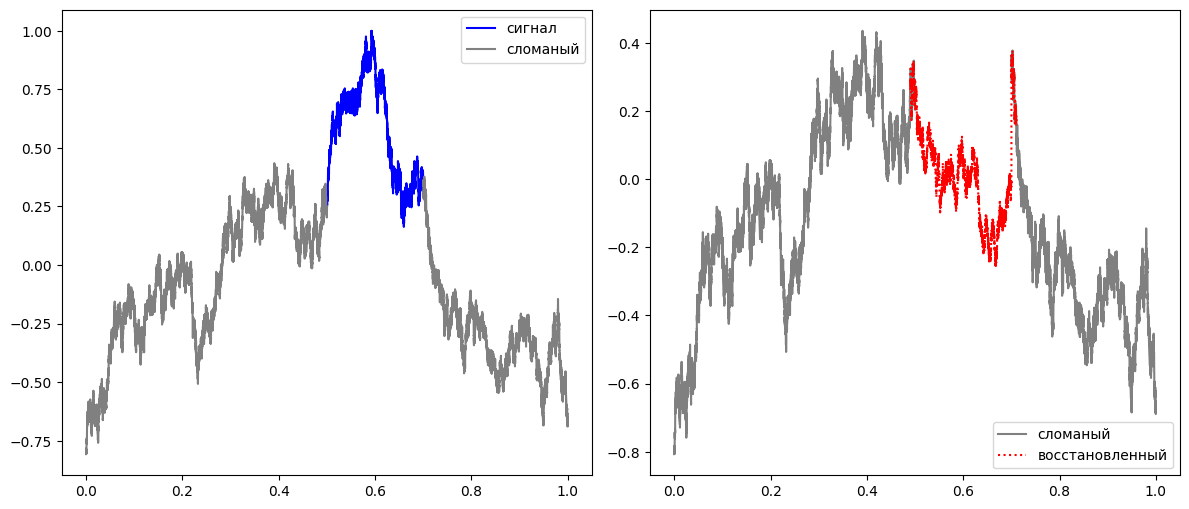

In [19]:
fig = plt.figure(figsize=(12,10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(221)
plt.plot(task5_timeseries[(task5_timeseries>left_delete_sig) & (task5_timeseries <right_delete_sig)], task5_sig[(task5_timeseries>left_delete_sig) & (task5_timeseries < right_delete_sig)] , color='blue', label='сигнал')
plt.plot(task5_timeseries_gapped, task5_sig_gapped, color='grey', label='сломаный')
plt.legend()

plt.subplot(222)
plt.plot(task5_timeseries_gapped, task5_sig_gapped, color='grey', label='сломаный')
plt.plot(task5_timeseries[(task5_timeseries>left_delete_sig-0.01) & (task5_timeseries < right_delete_sig+0.01)], restored_signal[(task5_timeseries>left_delete_sig-0.01) & (task5_timeseries < right_delete_sig+0.01)], color='red', label='восстановленный', linestyle='dotted')

plt.legend()
plt.tight_layout()
plt.show()

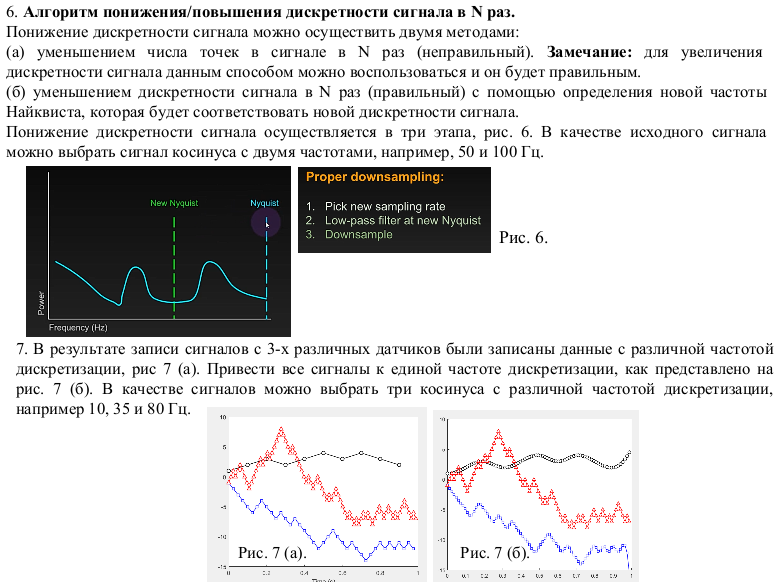

In [31]:
def upsample_signal(signal, original_sample_rate, new_sample_rate):
    # рассчитываем фактор интерполяции
    interpolation_factor = new_sample_rate / original_sample_rate
    # рассчитываем новую длину сигнала
    new_length = int(len(signal) * interpolation_factor)
    # интерполяция сигнала
    new_signal = np.interp(np.linspace(0, len(signal) - 1, new_length), np.arange(len(signal)), signal)
    return new_signal

def nyquist_downsample(signal, original_sample_rate, new_sample_rate):
    # рассчитываем частоту среза
    cutoff_frequency = original_sample_rate//2
    # рассчитываем состояния фильтрации
    N_state = int(original_sample_rate // new_sample_rate)
    sig_len = len(signal)
    # создаем фильтр Найквиста
    nyquist_filter = np.sinc(2 * cutoff_frequency * (np.arange(-sig_len//2, sig_len//2) / original_sample_rate))
    # свертки
    filtered_signal = np.convolve(signal, nyquist_filter, mode='same')
    # выполняем даунсемплинг сигнала
    downsampled_signal = filtered_signal[::N_state]
    return downsampled_signal

def calc_signal(s_func, *args, t_start = 0, t_end = 2, samples, noised=False):
    time_series = np.linspace(t_start, t_end, samples, endpoint=False)
    signal_vals = np.array([s_func(*args, t) for t in time_series])
    if noised: signal_vals += np.random.normal(0, 1, signal_vals.shape)
    return signal_vals, time_series

cos_50hzf = cos_signal_func(freq=50)
cos_100hzf = cos_signal_func(freq=2000)
cos_task6f = lambda x: cos_50hzf(x) + cos_100hzf(x)

signal_t6, timeseries_t6 = calc_signal(cos_task6f, samples=10000)

downsampled_rate = 2500
upsampled_rate = 7500
# Даунсемплинг
downsampled_signal_t6 = nyquist_downsample(signal_t6, 10000, downsampled_rate)
downsampled_timeseries = np.linspace(0, 2, len(downsampled_signal_t6), endpoint=False)
# Апсемплинг
upsampled_signal_t6 = upsample_signal(downsampled_signal_t6, downsampled_rate, upsampled_rate)
upsampled_timeseries = np.linspace(0, 2, len(upsampled_signal_t6), endpoint=False)

In [29]:
print(timeseries_t6)
print(1/(2 *())

[0.0000e+00 2.0000e-04 4.0000e-04 ... 1.9994e+00 1.9996e+00 1.9998e+00]
0.0001


In [30]:
t = timeseries_t6[1] -timeseries_t6[0]
print(1/(2*t))

2500.0


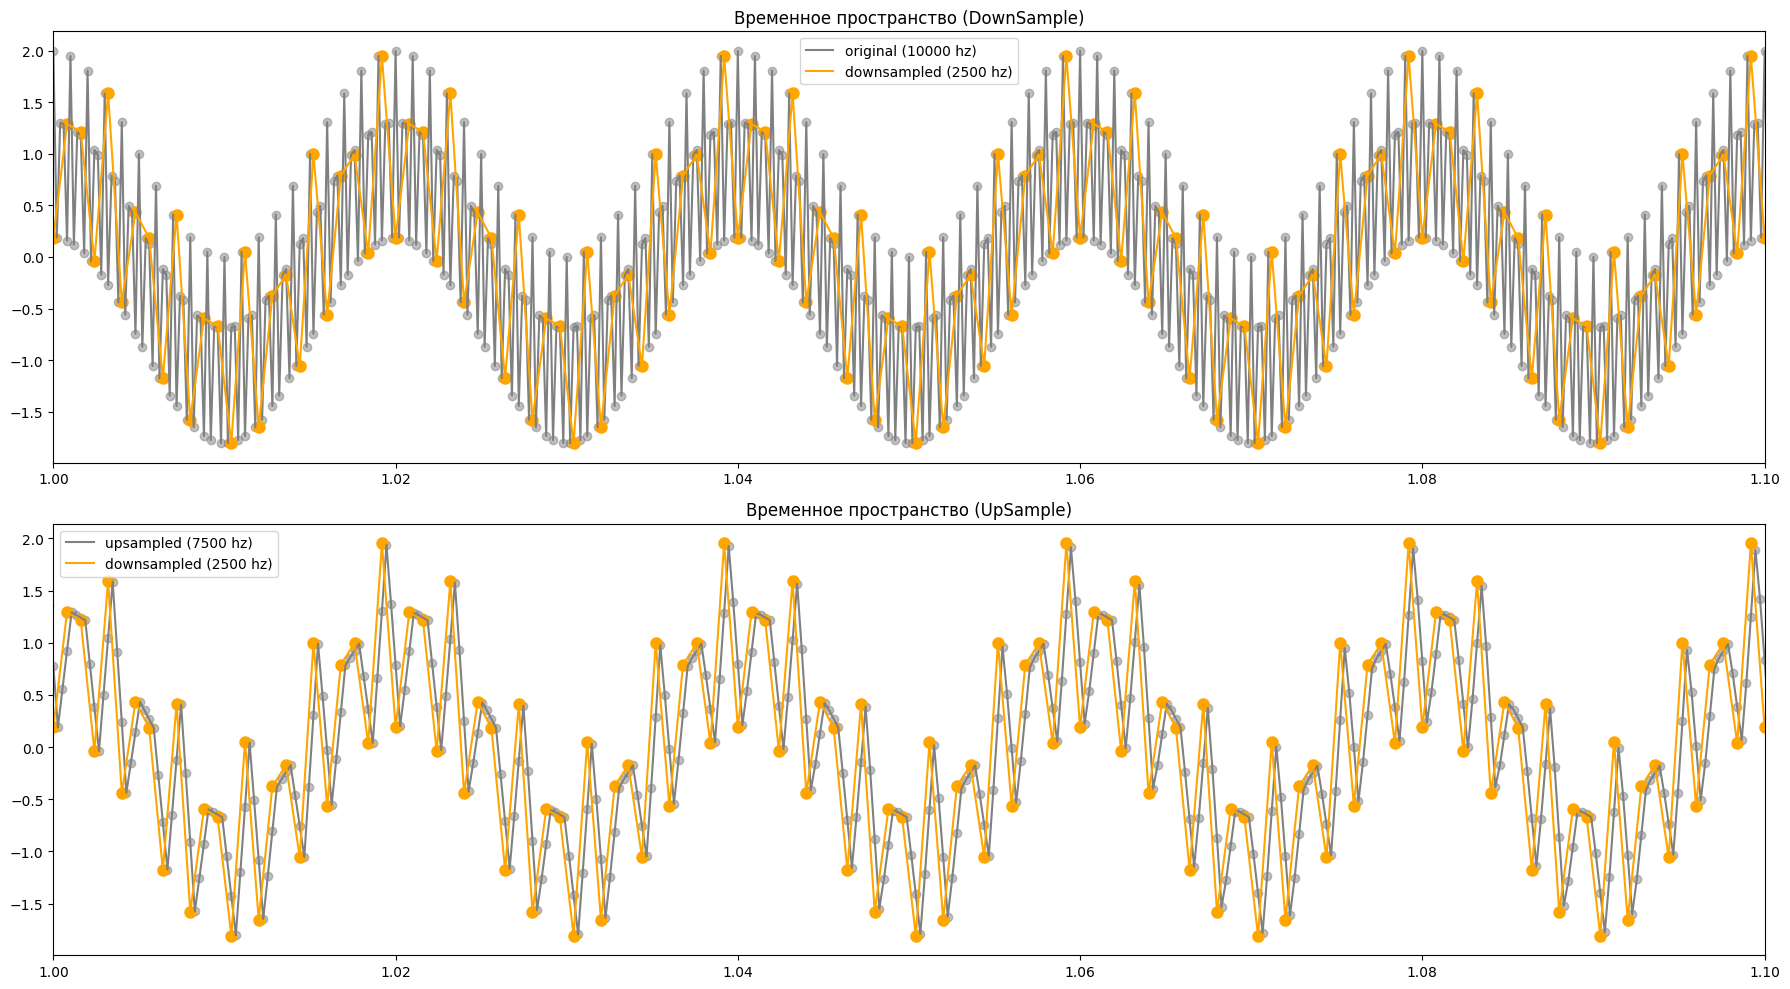

In [32]:
plt.figure(figsize=(18, 10))

plt.subplot(211)
plt.title("Временное пространство (DownSample)")
plt.plot(timeseries_t6, signal_t6, color='gray', label=f'original ({10000} hz)')
plt.scatter(timeseries_t6, signal_t6, color='gray', alpha=0.5)

plt.plot(downsampled_timeseries, downsampled_signal_t6, color='orange', label=f'downsampled ({downsampled_rate} hz)')
plt.scatter(downsampled_timeseries, downsampled_signal_t6, color='orange', lw=3)

plt.xlim([1, 1.1])
plt.legend()

plt.subplot(212)
plt.title("Временное пространство (UpSample)")
plt.plot(upsampled_timeseries, upsampled_signal_t6, color='grey', label=f'upsampled ({upsampled_rate} hz)')
plt.scatter(upsampled_timeseries, upsampled_signal_t6, color='grey', alpha=0.5)


plt.plot(downsampled_timeseries, downsampled_signal_t6, color='orange', label=f'downsampled ({downsampled_rate} hz)')
plt.scatter(downsampled_timeseries, downsampled_signal_t6, color='orange', lw=3)

plt.xlim([1, 1.1])
plt.legend()
plt.tight_layout()
plt.show()

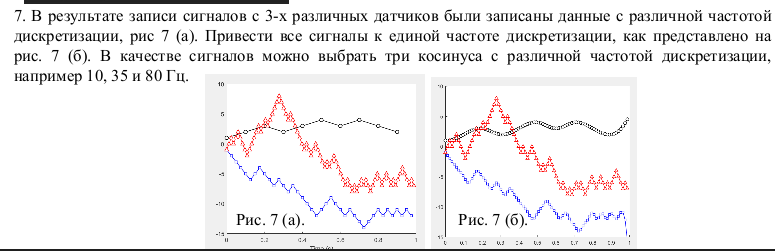

In [22]:
cos_50hzf = cos_signal_func(freq=50)

signal1_t6, timeseries1_t6 = calc_signal(cos_50hzf, t_end=0.1, samples=30)
signal2_t6, timeseries2_t6 = calc_signal(cos_50hzf, t_end=0.1, samples=50)
signal3_t6, timeseries3_t6 = calc_signal(cos_50hzf, t_end=0.1, samples=100)

signal1_t6_up = upsample_signal(signal1_t6, 30, 50)
timeseries1_t6_up = np.linspace(0, 0.1, len(signal1_t6_up))

signal3_t6_down = nyquist_downsample(signal3_t6, 100, 50)
timeseries3_t6_down = np.linspace(0, 0.1, len(signal3_t6_down))

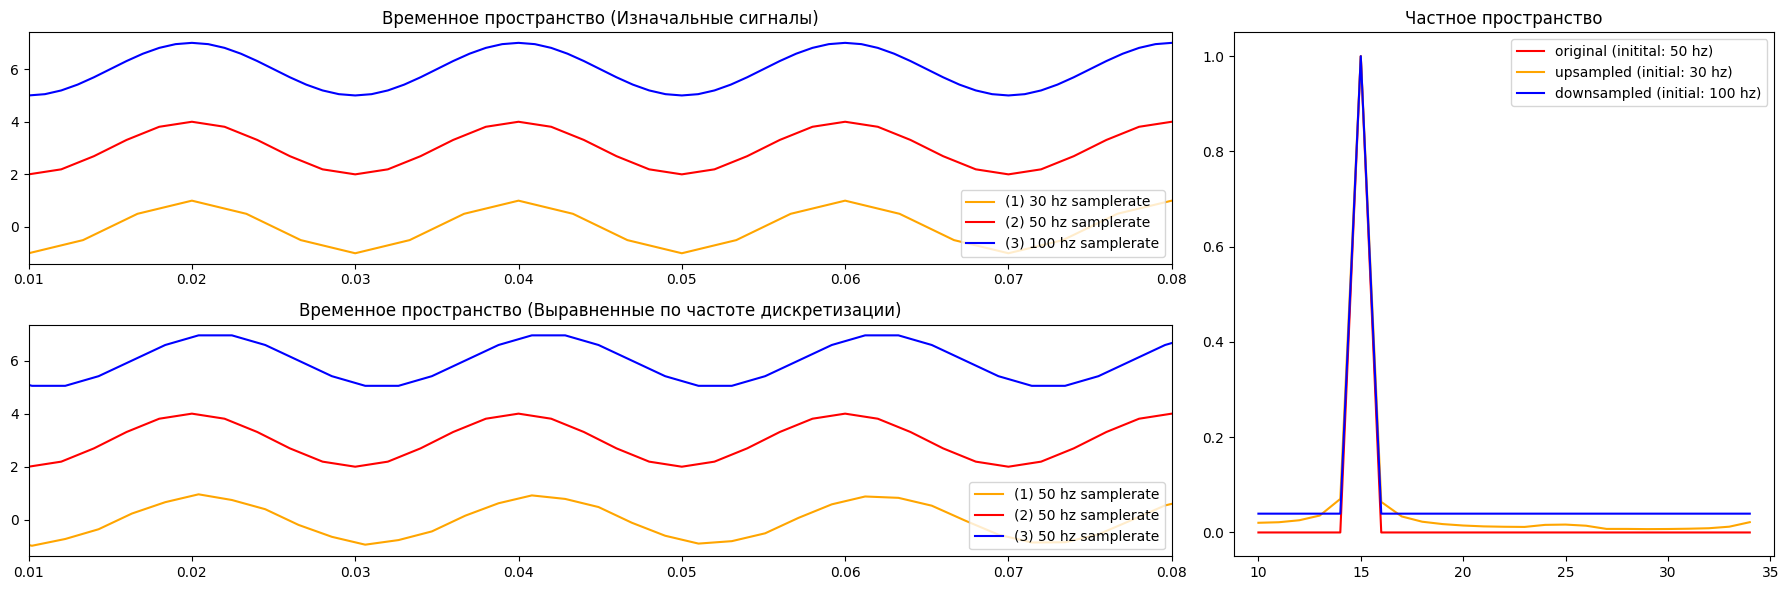

In [23]:
fig, ax = plt.subplot_mosaic(
    [["tl", "tl", "br"],
     ["bl", "bl", "br"]],
     figsize=(18,6)
)

ax['tl'].set_title("Временное пространство (Изначальные сигналы)")
ax['tl'].plot(timeseries1_t6, signal1_t6, color='orange', label='(1) 30 hz samplerate')
ax['tl'].plot(timeseries2_t6, signal2_t6 +3, color='red', label='(2) 50 hz samplerate')
ax['tl'].plot(timeseries3_t6, signal3_t6 +6, color='blue', label='(3) 100 hz samplerate')
ax['tl'].legend(loc="lower right")
ax['tl'].set_xlim([0.01,0.08])

ax['bl'].set_title("Временное пространство (Выравненные по частоте дискретизации)")
ax['bl'].plot(timeseries1_t6_up, signal1_t6_up, color='orange', label='(1) 50 hz samplerate')
ax['bl'].plot(timeseries2_t6, signal2_t6 +3, color='red', label='(2) 50 hz samplerate')
ax['bl'].plot(timeseries3_t6_down, signal3_t6_down+6, color='blue', label='(3) 50 hz samplerate')
ax['bl'].legend(loc="lower right")
ax['bl'].set_xlim([0.01,0.08])

ax['br'].set_title("Частное пространство")
s_2_spec_ch = get_positive_spectrum(signal2_t6, samplerate=50)
ax['br'].plot(s_2_spec_ch[0]+10, s_2_spec_ch[1], color='red', label="original (initital: 50 hz)")

s_1_spec_ch = get_positive_spectrum(signal1_t6_up, samplerate=50)
ax['br'].plot(s_1_spec_ch[0]+10, s_1_spec_ch[1], color='orange', label='upsampled (initial: 30 hz)')

s_3_spec_ch = get_positive_spectrum(signal3_t6_down, samplerate=50)
ax['br'].plot(s_3_spec_ch[0]+10, s_3_spec_ch[1], color='blue', label='downsampled (initial: 100 hz)')

ax['br'].legend()

plt.tight_layout()
plt.show()